In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import DatasetFolder
from torchvision import models
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from PIL import Image

import os
import numpy as np
import pandas as pd

#### Dataset Preparation

In [3]:
# 定义额外的转换
transform_pipeline = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop((800, 800), scale=(0.2, 0.5), ratio=(1,1), interpolation=2),
    transforms.Resize((512, 512)),
    # transforms.ToTensor()
])

# 设置图片文件夹路径和保存路径
image_folder_path = '2-Data/2-SEM/X5000/Test'
save_folder_path = '2-Data/2-SEM/X5000/AugmentationVL-P/Test'

# 确保保存路径存在
if not os.path.exists(save_folder_path):
    os.makedirs(save_folder_path)

# 遍历文件夹中的所有图片
for filename in os.listdir(image_folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff','.tif')):
        # 构建完整的文件路径
        image_path = os.path.join(image_folder_path, filename)

        name_without_extension = filename.split('.')[0]
        
        # 打开图片
        image = Image.open(image_path)
        #裁剪成（1500，1000）
        cropped_image = image.crop((0, 0, 1500, 1000))

        repeats = 20


        for k in range(repeats):
            #随机翻转图片
            transformed_crop = transform_pipeline(cropped_image)

            # transformed_image = transforms.functional.to_pil_image(crop)
            filename = f'{name_without_extension}-{k}.jpg'
            save_path = os.path.join(save_folder_path, filename)
            transformed_crop.save(save_path)
        # plt.show(crop)


#### Practical Models

In [5]:
# 数据准备
transform = transforms.Compose([
    transforms.ToTensor(),
    ])

dataset = datasets.ImageFolder(root=r'2-Data/2-SEM/X5000/AugmentationVL-P', transform=transform)


In [2]:
#定义VAE（卷积层）
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # 示例中假设输入是单通道图像
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 2048),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(2048, 64)  # 假设最终的特征图大小为 25x25x128
        self.fc_logvar = nn.Linear(2048, 64)

        # 解码器
        self.decoder_fc1 = nn.Linear(64, 2048)
        self.decoder_fc2 = nn.Linear(2048, 256 * 16 * 16)
        self.relu = nn.ReLU()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2,padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2,padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2,padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.decoder_fc1(z))
        h = self.relu(self.decoder_fc2(h))
        h = h.view(-1, 256, 16, 16)  # 重塑张量以匹配解码器的输入维度
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [21]:
#定义VAE（卷积层）
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=4, padding=2),  # 示例中假设输入是单通道图像
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            # nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 1024),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(1024, 64)  # 假设最终的特征图大小为 25x25x128
        self.fc_logvar = nn.Linear(1024, 64)

        # 解码器
        self.decoder_fc1 = nn.Linear(64, 1024)
        self.decoder_fc2 = nn.Linear(1024, 128 * 16 * 16)
        self.relu = nn.ReLU()
        self.decoder = nn.Sequential(
            # nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2,padding=1, output_padding=1),
            # nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2,padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2,padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=5, stride=4, padding=2, output_padding=3),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.decoder_fc1(z))
        h = self.relu(self.decoder_fc2(h))
        h = h.view(-1, 128, 16, 16)  # 重塑张量以匹配解码器的输入维度
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [8]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)

In [13]:
convae = ConvVAE()
X = torch.rand(size=(256, 3, 512, 512), dtype=torch.float32)
#X = X.to('cuda')
for layer in convae.encoder:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)
X = torch.rand(size=(256,128,16,16), dtype=torch.float32)
#X = X.to('cuda')
for layer in convae.decoder:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([256, 16, 128, 128])
ReLU output shape: 	 torch.Size([256, 16, 128, 128])
Conv2d output shape: 	 torch.Size([256, 32, 64, 64])
ReLU output shape: 	 torch.Size([256, 32, 64, 64])
Conv2d output shape: 	 torch.Size([256, 64, 32, 32])
ReLU output shape: 	 torch.Size([256, 64, 32, 32])
Conv2d output shape: 	 torch.Size([256, 128, 16, 16])
ReLU output shape: 	 torch.Size([256, 128, 16, 16])
Flatten output shape: 	 torch.Size([256, 32768])
Linear output shape: 	 torch.Size([256, 1024])
ReLU output shape: 	 torch.Size([256, 1024])
ConvTranspose2d output shape: 	 torch.Size([256, 64, 32, 32])
ReLU output shape: 	 torch.Size([256, 64, 32, 32])
ConvTranspose2d output shape: 	 torch.Size([256, 32, 64, 64])
ReLU output shape: 	 torch.Size([256, 32, 64, 64])
ConvTranspose2d output shape: 	 torch.Size([256, 16, 128, 128])
ReLU output shape: 	 torch.Size([256, 16, 128, 128])
ConvTranspose2d output shape: 	 torch.Size([256, 3, 512, 512])
Sigmoid output shape: 	 torch.S

In [9]:
#定义损失函数
def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x, reduction='sum')

    # KL散度损失
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


In [ ]:
# from torch.utils.tensorboard import SummaryWriter

# # 初始化SummaryWriter
# writer = SummaryWriter('runs/ConvVAE-2')
#训练循环
def train(model, num_epochs,dataloader, device, optimizer):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        # gradient_norms = [] 
        for data in dataloader:
            #print (data.shape)
            data = data[0].to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            #print(recon_batch.shape)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            #print(loss)

            # # 计算并记录梯度范数
            # for name, param in model.named_parameters():
            #     if param.grad is not None:
            #         grad_norm = torch.norm(param.grad).item()
            #         gradient_norms.append(grad_norm)
            #         writer.add_scalar(f'Gradients/{name}_grad_norm', grad_norm, epoch)

        # 记录每个epoch的平均损失
        epoch_loss /= len(dataloader)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
        # writer.add_scalar('Loss/train', epoch_loss, epoch)

    #     # 记录模型参数的梯度
    #     for name, param in model.named_parameters():
    #         writer.add_histogram(f'Gradients/{name}', param.grad, epoch)

        
    #     # 记录所有参数的平均梯度范数
    #     if gradient_norms:
    #         avg_gradient_norm = np.mean(gradient_norms)
    #         writer.add_scalar('Gradients/avg_grad_norm', avg_gradient_norm, epoch)


    # # 关闭SummaryWriter
    # writer.close()


# 训练模型
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = ConvVAE().to(device)
learning_rate = 5e-4
batch_size = 1024
epochs = 20
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
train(model, epochs, dataloader, device, optimizer)


#### 图像输出

In [3]:
def print_image(data,model,num_pic, device):
    fig = plt.figure(figsize=(10,5*num_pic))
    for i in range (num_pic):
        image_raw = data[i][0]
        # print('raw_image:',image_raw.shape,image_raw)
        image_init = image_raw.squeeze(0)
        image_show = torch.sum(image_init,0)
        image_show = image_show / image_init.shape[0]
        a = fig.add_subplot(num_pic, 2, 2*i+1)
        # print('raw_image:',image_show.shape,image_show)
        plt.imshow(image_show.detach().cpu().numpy(),cmap='gray')
        image_raw = image_raw.to(device)
        #print(type(image_raw))
        model.eval()
        model.to(device)
        image,_,_ = model(image_raw.unsqueeze(0).float())
        #print(image.shape)
        image = image.squeeze()
        image_ = torch.sum(image,0)
        image_ = image_ / image.shape[0]
        # print(image)
        # image_ = image
        image_ = image_.detach().cpu().numpy()
        # print('restored_image:',image_.shape,image_)
        a = fig.add_subplot(num_pic, 2, 2*i+2)
        plt.imshow(image_,cmap='gray')

In [22]:
# 创建模型实例
model = ConvVAE()

# 指定保存的模型权重文件的路径
path_to_saved_model = r'./modelsVL-S3e-4/model_epoch_5000.pth'

# 加载状态字典
state_dict = torch.load(path_to_saved_model)

# 将状态字典加载到模型中
model.load_state_dict(state_dict)

# 确保模型处于正确的设备上
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model.to(device)

# 现在模型已经加载了保存的权重，可以用于推理或继续训练


/tmp/ipykernel_1212353/713128767.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path_to_saved_model)


ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=32768, out_features=1024, bias=True)
    (10): ReLU()
  )
  (fc_mu): Linear(in_features=1024, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=1024, out_features=64, bias=True)
  (decoder_fc1): Linear(in_features=64, out_features=1024, bias=True)
  (decoder_fc2): Linear(in_features=1024, out_features=32768, bias=True)
  (relu): ReLU()
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, 

In [5]:
# 数据准备
transform = transforms.Compose([
#     transforms.CenterCrop(size=(500,500)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.5),
# #    transforms.RandomRotation(degrees=180, expand=True, center=None),
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    ])

test_dataset = datasets.ImageFolder(root=r'2-Data/2-SEM/X5000/AugmentationVL', transform=transform)


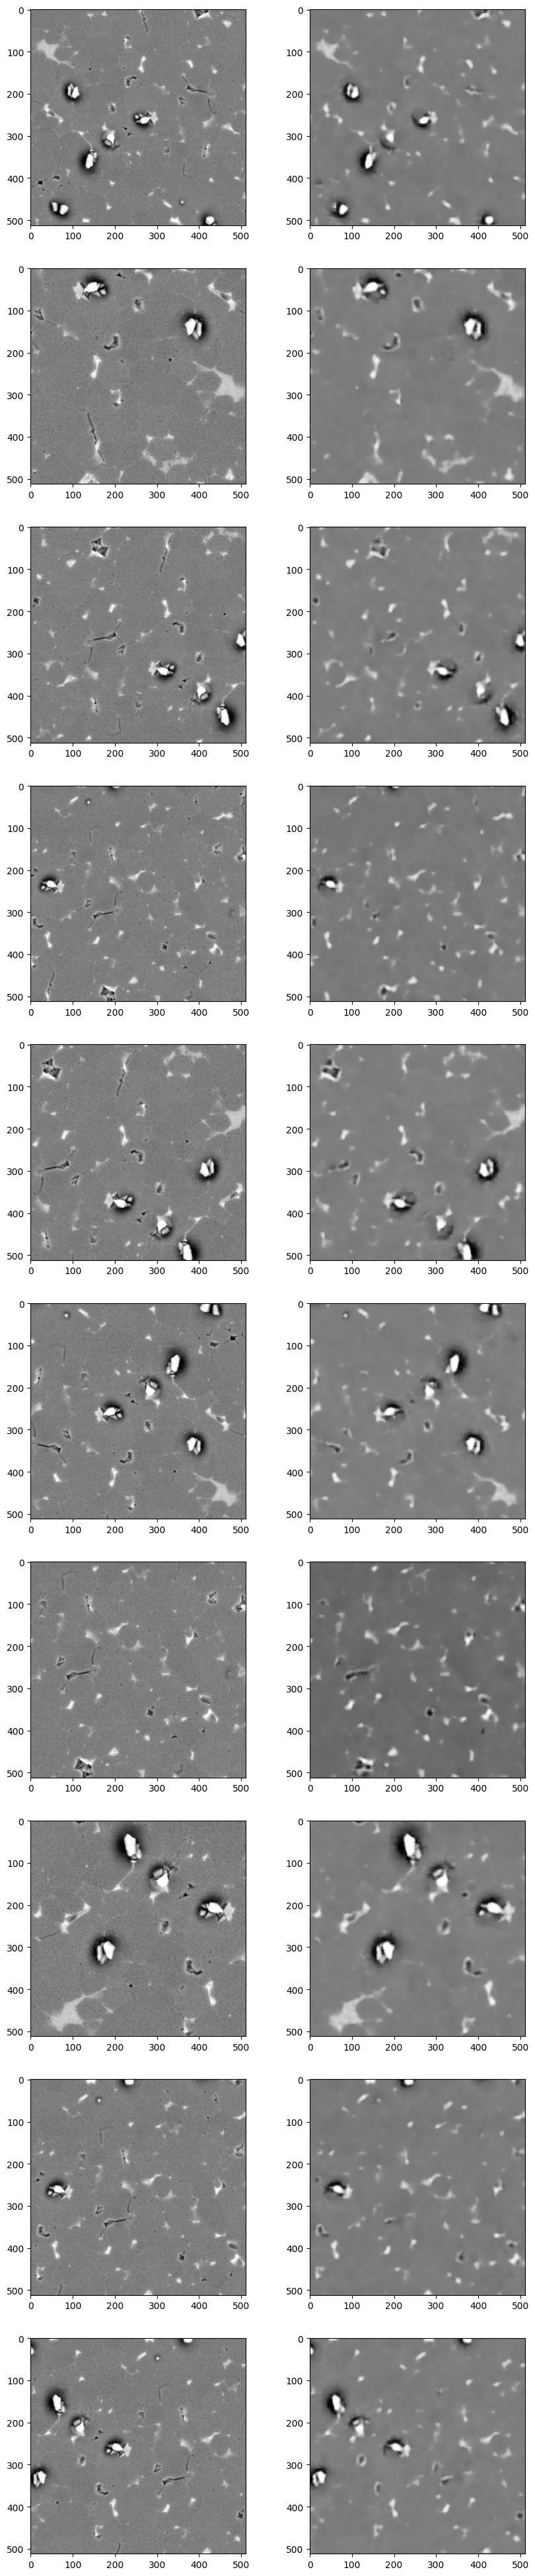

In [23]:
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)
print_image(dataloader.dataset,model,10,device)

In [3]:
image_path= r'./2-Data/2-SEM/X5000/Train/1-1x5000.tif' 
image = Image.open(image_path)
print(image.size)

(1536, 1103)


In [ ]:
def print_single_image(img_path,model,num_pic):
    fig = plt.figure(figsize=(10,45))
    for i in range (num_pic):
        image_raw = Image.open(img_path)
        # print('raw_image:',image_raw.shape,image_raw)
        image_show = torch.sum(image_raw,0)
        image_show = image_show / image_raw.shape[0]
        a = fig.add_subplot(num_pic, 2, 2*i+1)
        # print('raw_image:',image_show.shape,image_show)
        plt.imshow(image_show.detach().cpu().numpy(),cmap='gray')
        image_raw = image_raw.to('cuda')
        #print(type(image_raw))
        model.eval()
        model.to('cuda')
        image,_,_ = model(image_raw.unsqueeze(0).float())
        #print(image.shape)
        image = image.squeeze()
        image_ = torch.sum(image,0)
        image_ = image_ / image.shape[0]
        # print(image)
        # image_ = image
        image_ = image_.detach().cpu().numpy()
        # print('restored_image:',image_.shape,image_)
        a = fig.add_subplot(num_pic, 2, 2*i+2)
        plt.imshow(image_,cmap='gray')

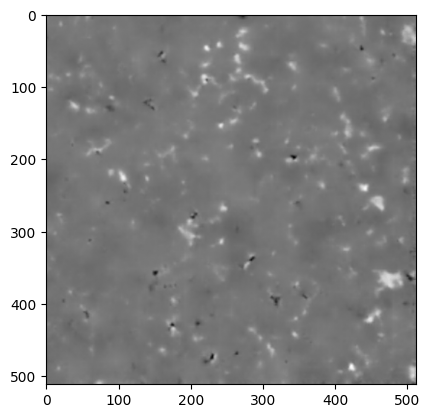

In [20]:
# 假设你有一个编码后的隐向量 z
z = torch.randn(1, 64)  # 假设 z 是一个 16x16 的随机张量

# 确保模型处于正确的设备上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 单独调用解码器
with torch.no_grad():  # 确保不会计算梯度
    decoded_output = model.decode(z.to(device))


image = decoded_output.squeeze()
image_ = torch.sum(image,0)
image_ = image_ / image.shape[0]
# print(image)
# image_ = image
image_ = image_.detach().cpu().numpy()
# print('restored_image:',image_.shape,image_)
plt.imshow(image_,cmap='gray')
# decoded_output 就是解码器的输出
